### Background

Zuclopenthixol is an antipsychotic used for schizophrenia and other types psychoses. In the UK, there are two injecatable forms available
 - Zuclopenthixol **acetate** : a short acting treatment used for acute episodes 
 - Zuclopenthixol **decanoate** : a long acting treatment used for maintenance
 
 The [BNF has a safety warning](https://bnf.nice.org.uk/drug/zuclopenthixol-acetate.html) on both medicines advising that **acetate** preparartions are used in hospitals in acute episodes while **deconate** preparations are used in the community. The implcation being that **acetate** should not be prescribed in primary care. The East London Foundation Trusts Medication safety team have a [YouTube video](https://www.youtube.com/watch?v=Fac0QjO8J_Y&list=PLeEBLpkk4vtPZZFhJ0bWw79VwmRf39J97&index=1) discussing some of the issues with **acetate** and you can see similarities in the prouct packs.
 
 Initial analysis of the Analyse page reports [30,398 items for **Decanoate**](https://openprescribing.net/analyse/#org=CCG&numIds=0402020Z0&denom=nothing&selectedTab=summary) and [61 items for **acetate**](https://openprescribing.net/analyse/#org=CCG&numIds=040201010&denom=total_list_size&selectedTab=summary) in the last 12 months. We have been told that quite often **acetate** is prescribed in error in primary care and really if it should not be prescribed it should not be available on the picking list. This notebook aims to examine prescribing patterns and mock up a measure of prescribing.

### Imports and Data Manipulation

In [1]:
#import libraries required for analysis
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from ebmdatalab import bq
from ebmdatalab import charts
from ebmdatalab import maps
import matplotlib.gridspec as gridspec

In [2]:
sql = """
WITH
bnf_tab AS (
SELECT
DISTINCT chemical,
chemical_code
FROM
ebmdatalab.hscic.bnf )
SELECT
rx.month,
TRIM(Principal_Supplier) AS supplier,
rx.practice,
rx.pct,
SUBSTR(rx.bnf_code,1,9) AS chemical_code,
chemical,
sum(IF(rx.bnf_code LIKE "040201010%", items,0)) AS acetate,
sum(IF(rx.bnf_code LIKE "0402020Z0%", items,0)) AS decanoate,
sum(items) AS total_zuclo,
sum(actual_cost) as total_cost
FROM
hscic.normalised_prescribing_standard AS rx
LEFT JOIN
bnf_tab
ON
chemical_code =SUBSTR(rx.bnf_code,1,9)
JOIN
hscic.practice_statistics AS prac
ON
rx.practice = prac.practice AND prac.month = rx.month
JOIN
  alex.vendors AS software
ON
  software.ODS = rx.practice
  AND Date = rx.month
JOIN
  hscic.practices as practices
ON
  practices.code = software.ODS
WHERE
  practices.setting = 4
  AND total_list_size > 100
  AND (bnf_code LIKE "040201010%" OR ##acetate
  bnf_code LIKE "0402020Z0%") ##Decanoate
GROUP BY
rx.month,
supplier,
rx.practice,
rx.pct,
chemical_code,
chemical
ORDER BY
month"""

df_zuclo = bq.cached_read(sql, csv_path='zuclo.csv')
df_zuclo['month'] = df_zuclo['month'].astype('datetime64[ns]')
df_zuclo.head(3)

,month,supplier,practice,pct,chemical_code,chemical,acetate,decanoate,total_zuclo,total_cost
0,2016-01-01,EMIS,M91650,05Y,0402020Z0,Zuclopenthixol Decanoate,0,2,2,23.50
1,2016-01-01,EMIS,Y02423,08X,0402020Z0,Zuclopenthixol Decanoate,0,2,2,83.36
2,2016-01-01,EMIS,M86605,05A,0402020Z0,Zuclopenthixol Decanoate,0,2,2,19.78


In [3]:
##here we check the BNF name to see if products included look correct and no coding changes.
df_zuclo["chemical"].unique()

array(['Zuclopenthixol Decanoate', 'Zuclopenthixol Acetate'], dtype=object)

In [4]:
df_decan = df_zuclo.loc[df_zuclo["chemical"] == "Zuclopenthixol Decanoate"]
df_decan.head()

,month,supplier,practice,pct,chemical_code,chemical,acetate,decanoate,total_zuclo,total_cost
0,2016-01-01,EMIS,M91650,05Y,0402020Z0,Zuclopenthixol Decanoate,0,2,2,23.50
1,2016-01-01,EMIS,Y02423,08X,0402020Z0,Zuclopenthixol Decanoate,0,2,2,83.36
2,2016-01-01,EMIS,M86605,05A,0402020Z0,Zuclopenthixol Decanoate,0,2,2,19.78
3,2016-01-01,EMIS,Y02624,05Y,0402020Z0,Zuclopenthixol Decanoate,0,2,2,40.87
4,2016-01-01,EMIS,K81040,15A,0402020Z0,Zuclopenthixol Decanoate,0,4,4,160.88


In [5]:
df_acetate = df_zuclo.loc[df_zuclo["chemical"] == "Zuclopenthixol Acetate"]
df_acetate.head()


,month,supplier,practice,pct,chemical_code,chemical,acetate,decanoate,total_zuclo,total_cost
425,2016-01-01,EMIS,F81018,06T,040201010,Zuclopenthixol Acetate,1,0,1,9.05
516,2016-01-01,EMIS,M88007,05L,040201010,Zuclopenthixol Acetate,1,0,1,35.89
521,2016-01-01,EMIS,M92024,06A,040201010,Zuclopenthixol Acetate,1,0,1,22.37
763,2016-01-01,TPP,L84046,11M,040201010,Zuclopenthixol Acetate,1,0,1,44.73
1062,2016-01-01,EMIS,N85044,12F,040201010,Zuclopenthixol Acetate,1,0,1,4.58


In [7]:
df_acetate_measure = df_zuclo.copy()

df_acetate_measure["measure_value"] = 100*(df_zuclo.acetate / df_zuclo.total_zuclo).fillna(0)
df_acetate_measure.head()

,month,supplier,practice,pct,chemical_code,chemical,acetate,decanoate,total_zuclo,total_cost,measure_value
0,2016-01-01,EMIS,M91650,05Y,0402020Z0,Zuclopenthixol Decanoate,0,2,2,23.50,0.0
1,2016-01-01,EMIS,Y02423,08X,0402020Z0,Zuclopenthixol Decanoate,0,2,2,83.36,0.0
2,2016-01-01,EMIS,M86605,05A,0402020Z0,Zuclopenthixol Decanoate,0,2,2,19.78,0.0
3,2016-01-01,EMIS,Y02624,05Y,0402020Z0,Zuclopenthixol Decanoate,0,2,2,40.87,0.0
4,2016-01-01,EMIS,K81040,15A,0402020Z0,Zuclopenthixol Decanoate,0,4,4,160.88,0.0


In [8]:
df_acetate_measure.sort_values("measure_value", ascending=False).head(5)

,month,supplier,practice,pct,chemical_code,chemical,acetate,decanoate,total_zuclo,total_cost,measure_value
4769,2016-04-01,EMIS,B81057,03F,040201010,Zuclopenthixol Acetate,1,0,1,44.82000,100.0
7552,2016-06-01,EMIS,F81018,06T,040201010,Zuclopenthixol Acetate,1,0,1,9.07000,100.0
425,2016-01-01,EMIS,F81018,06T,040201010,Zuclopenthixol Acetate,1,0,1,9.05000,100.0
31659,2018-01-01,EMIS,J82051,11A,040201010,Zuclopenthixol Acetate,2,0,2,9.19482,100.0
5189,2016-04-01,EMIS,K81026,15A,040201010,Zuclopenthixol Acetate,1,0,1,22.42000,100.0


In [9]:
ccg_acetate_measure = df_acetate_measure.groupby(["pct", "month"], as_index=False).sum()
ccg_acetate_measure.head()

,pct,month,acetate,decanoate,total_zuclo,total_cost,measure_value
0,00C,2016-01-01,0,8,8,141.26,0.0
1,00C,2016-02-01,0,9,9,118.41,0.0
2,00C,2016-03-01,0,3,3,92.79,0.0
3,00C,2016-04-01,0,1,1,34.42,0.0
4,00C,2016-05-01,0,12,12,170.38,0.0


In [10]:
ccg_acetate_measure["measure_value"] = (ccg_acetate_measure["acetate"] / ccg_acetate_measure["total_zuclo"])*100
ccg_acetate_measure.head()

,pct,month,acetate,decanoate,total_zuclo,total_cost,measure_value
0,00C,2016-01-01,0,8,8,141.26,0.0
1,00C,2016-02-01,0,9,9,118.41,0.0
2,00C,2016-03-01,0,3,3,92.79,0.0
3,00C,2016-04-01,0,1,1,34.42,0.0
4,00C,2016-05-01,0,12,12,170.38,0.0


 ### Charts and Graphs

(0, 3000)

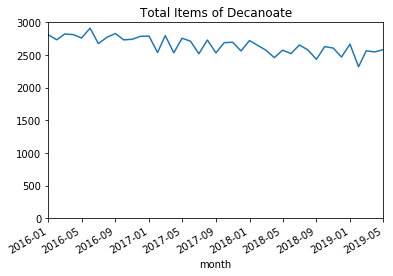

In [11]:
df_decan.groupby("month")['decanoate'].sum().plot(kind='line', title="Total Items of Decanoate")
plt.ylim(0, 3000)

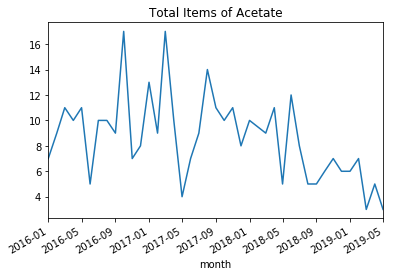

In [12]:
df_acetate.groupby("month")['acetate'].sum().plot(kind='line', title="Total Items of Acetate")

Above we have created a measure of All Acetate Items as a proprotion of all Injectable Zuclopenthixol. Lets look at variation

C:\Users\bmackenna\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


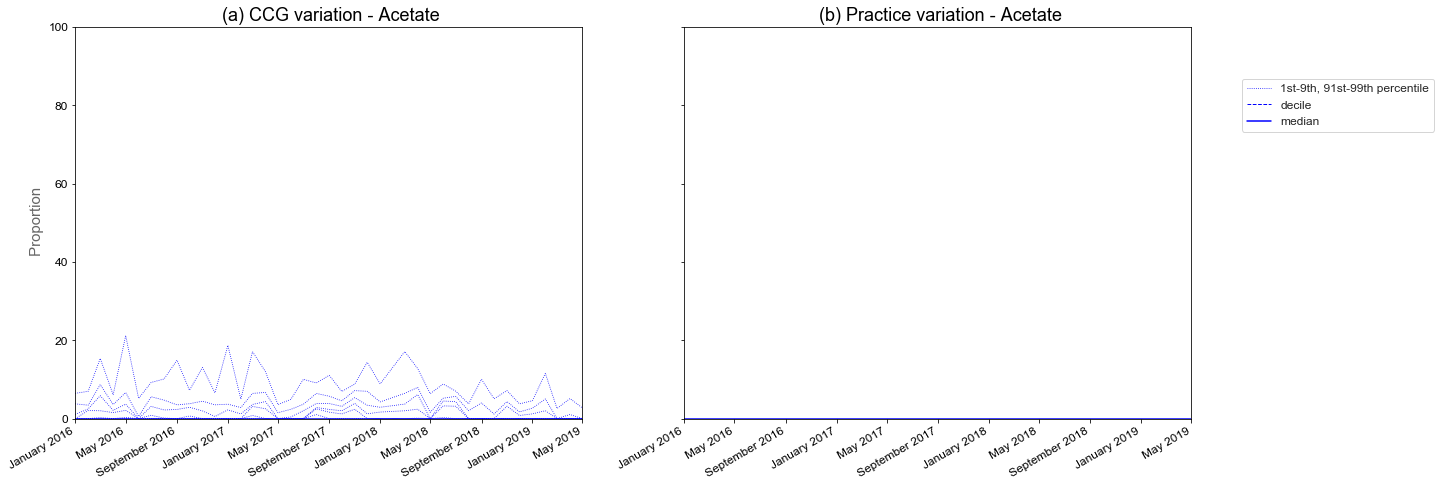

In [13]:
f = plt.figure(figsize=(20,8))
#f.suptitle('Sharing Y axis')
f.autofmt_xdate()
layout = gridspec.GridSpec(1, 2, figure=f)
left_plot = plt.subplot(layout[0])
right_plot = plt.subplot(layout[1], sharey=left_plot)  # Share the Y axis 

# ...and because it's shared, suppress ticks on the second chart
plt.setp(right_plot.get_yticklabels(), visible=False)

charts.deciles_chart(
    ccg_acetate_measure,
    period_column='month',
    column='measure_value',
    title=" (a) CCG variation - Acetate",
    ylabel=" Proportion",
    show_outer_percentiles=True,
    show_legend=False,
    ax=left_plot, 
) 


charts.deciles_chart(
    df_acetate_measure,
    period_column='month',
    column='measure_value',
    title=" (b) Practice variation - Acetate",
    ylabel="",
    show_outer_percentiles=True,
    show_legend=True,
    ax=right_plot,
) 

plt.ylim(0, 100)
plt.show()

In [14]:
## question is the practice zero because the numbers are just so low? Lets look at a specific practice where we know there is prescribing

C:\Users\bmackenna\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


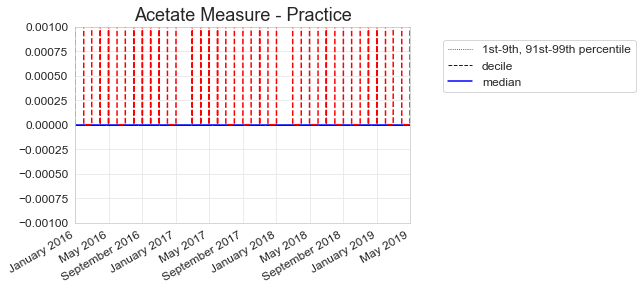

In [15]:
#create sample deciles

charts.deciles_chart(
        df_acetate_measure,
        period_column='month',
        column='measure_value',
        title="Acetate Measure - Practice",
        show_outer_percentiles=True)

#add in example practice - Melrose K81651
df_subject = df_acetate_measure.loc[df_acetate_measure['practice'] == 'K81651']
plt.plot(df_subject['month'], df_subject['measure_value'], 'r--')

plt.show()

In [27]:
## here we look for 99th percentile value
df_acetate_measure.measure_value.quantile(0.99)

0.0

In [ ]:
It is zero so practices chat should look empty due to 

### EHR
Let us see if there is any effect of the EHR. Perhaps one of the EHY suppliers has suppressed acetate to prevent mistakes. In dm+d there is a "hospital field" and it is listed at the AMPP level. however [Clopixol Acuphase](https://openprescribing.net/dmd/ampp/4130211000001100/) does not have the field applied indicating it should only be used in hospital. Therefore it is unlikely to see how these products would be suppressed on a systematic basis

In [16]:
df = df_acetate.groupby(['month','supplier'])['total_zuclo'].sum().reset_index()
df.head(10)

,month,supplier,total_zuclo
0,2016-01-01,EMIS,6
1,2016-01-01,TPP,1
2,2016-02-01,EMIS,7
3,2016-02-01,TPP,2
4,2016-03-01,EMIS,9
5,2016-03-01,TPP,2
6,2016-04-01,EMIS,9
7,2016-04-01,TPP,1
8,2016-05-01,EMIS,10
9,2016-05-01,TPP,1


Text(0.5,1,'Zuclopenthixol Acetate, total items per supplier')

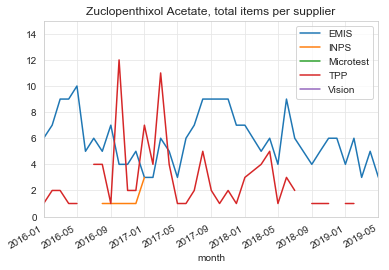

In [17]:
df_acetate.groupby(['month', 'supplier']).sum()['total_zuclo'].unstack().plot.line()
plt.legend(loc='best')
plt.ylim(0, 15)
plt.title("Zuclopenthixol Acetate, total items per supplier")

Text(0.5,1,'Zuclopenthixol Decanoate, total items per supplier')

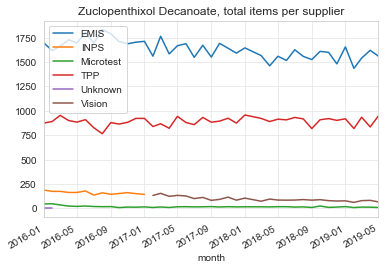

In [18]:
df_decan.groupby(['month', 'supplier']).sum()['total_zuclo'].unstack().plot.line()
plt.legend(loc='upper left')
plt.title("Zuclopenthixol Decanoate, total items per supplier")

The numbers of **acetate** are just too low to draw any meaningful conclusion about picking screen choices. 



### Conclusion
There is limited prescribing of acetate however any breach of guidance is worthy of investigation. We can
- Deploy a measure immediately
- Deploy a measure plus run a study on finding out why it is prescribed in primary care. This would be similar to Nimodipine (ethics amendement needed) or potentially in the outlier detection study.
- Share notebook with intreested parties who may have greater expertise on this
- Investigate dmd hospital flag a bit more
- Check picking screens on EHR. Maybe acetate is suppressed already and these are genuine scripts and not picking errors
